In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


STEP 1: Data Preprocessing

In [ ]:
# Load data
df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Display the first few rows of the dataset
print(df.head())

# Check the data types and missing values in each column
print(df.info())

# Check for missing values
print(df.isnull().sum())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)


In [ ]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)


In [ ]:
# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [ ]:
# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [ ]:
# Recheck data types and look for any anomalies
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
 8   TotalPrice   401604 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.6+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  401604.000000                         401604  401604.000000   
mean       12.183273  2011-07-10 12:08:23.848567552       3.474064   
min    -80995.000000            2010-12-01 08:26

STEP 2: RFM Calculation:

In [ ]:
# Define the reference date as the latest date in the dataset
reference_date = df['InvoiceDate'].max()

# Group by CustomerID to calculate Recency, Frequency, and Monetary metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency: Days since last purchase
    'InvoiceNo': 'nunique',  # Frequency: Number of unique purchases
    'TotalPrice': 'sum'      # Monetary: Total spend
})

# Rename columns for easier reference
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display the RFM table
print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          2      0.00
12347.0           1          7   4310.00
12348.0          74          4   1797.24
12349.0          18          1   1757.55
12350.0         309          1    334.40


STEP 3: RFM Segmentation

In [ ]:
# Assign scores based on quartiles for each RFM metric
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')  # Lower recency is better
# Get the unique quantiles for Frequency
quantiles = pd.qcut(rfm['Frequency'], 4, duplicates='drop').cat.categories
num_quantiles = len(quantiles)  # Get the number of unique quantiles
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=range(1, num_quantiles + 1), duplicates='drop')  # Higher frequency is better
# Get the unique quantiles for Monetary
quantiles = pd.qcut(rfm['Monetary'], 4, duplicates='drop').cat.categories
num_quantiles = len(quantiles)  # Get the number of unique quantiles
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=range(1, num_quantiles + 1), duplicates='drop')  # Higher monetary is better

# Combine RFM scores to create a single RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the RFM table with scores
print(rfm[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head())

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
12346.0         325          2      0.00       1       1       1       111
12347.0           1          7   4310.00       4       3       4       434
12348.0          74          4   1797.24       2       2       4       224
12349.0          18          1   1757.55       3       1       4       314
12350.0         309          1    334.40       1       1       2       112


STEP 4: Customer Segmentation

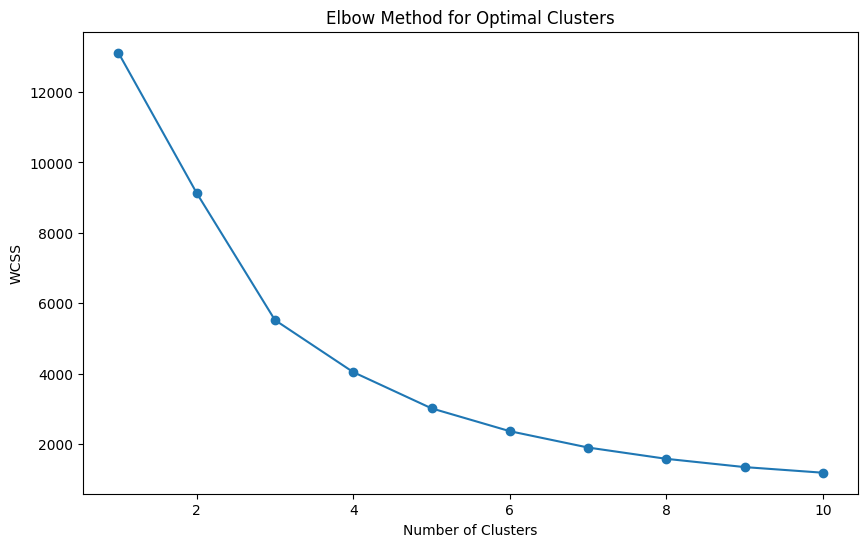

            Recency   Frequency       Monetary  CustomerCount
Cluster                                                      
0          9.787565   28.575130   12190.961710            193
1        247.927577    1.805942     453.425572           1077
2          4.090909  109.909091  124150.432727             11
3         41.768360    4.374313    1317.266164           3091


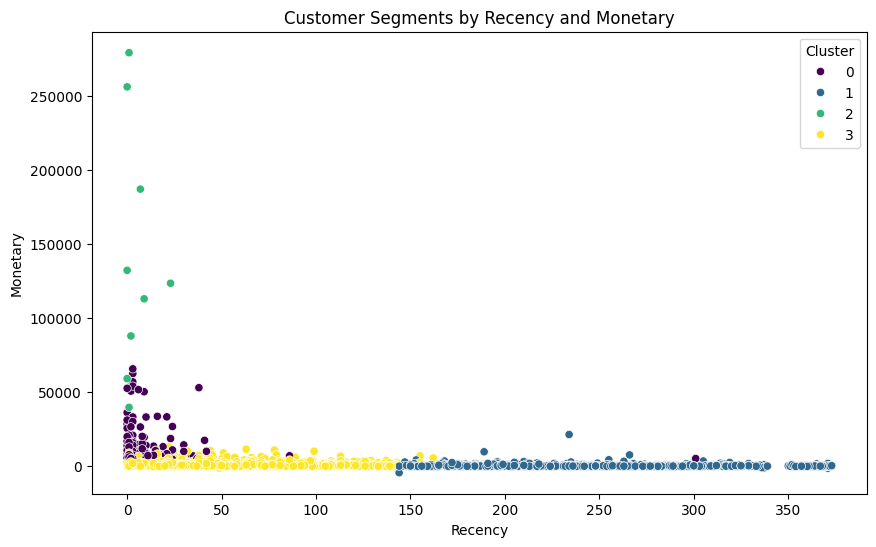

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize RFM data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Apply KMeans with the chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Summarize clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'count'
}).rename(columns={'RFM_Score': 'CustomerCount'})

print(cluster_summary)

# Visualize clusters by Recency and Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='viridis')
plt.title('Customer Segments by Recency and Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()


STEP 5 : Segment Profiling

Calculating the RFM Metrics

In [ ]:
import pandas as pd
# Load the data
data = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Step 1: Recency Calculation
# Define the reference date for recency calculation (latest date in the dataset + 1)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate Recency for each customer
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Days since last purchase
    'InvoiceNo': 'nunique',  # Frequency: number of unique invoices
    'UnitPrice': lambda x: (x * data.loc[x.index, 'Quantity']).sum()  # Monetary: total spend
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'})

# Step 2: Assign RFM Scores
# Assign quartile scores for Recency, Frequency, and Monetary
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine RFM scores into a single RFM_Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Step 3: Clustering (K-Means)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust number of clusters if needed
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 4: Merge RFM Data with Original Dataset
data = data.merge(rfm, on='CustomerID')

print("RFM metrics calculated and clustering completed.")


RFM metrics calculated and clustering completed.


Cluster Profiles:
   Cluster     Recency   Frequency      Monetary  Customer_Count  \
0        0    8.931691   33.864297  15265.228834           81936   
1        1  233.447494    2.674316    839.410710           30244   
2        2    2.690789  163.206279  89796.821676           29019   
3        3   31.563476    6.990381   2336.111010          265630   

                              Cluster_Description  
0     High Recency, High Frequency, High Monetary  
1  Low Recency, High Frequency, Moderate Monetary  
2       High Recency, Low Frequency, Low Monetary  
3       High Recency, Low Frequency, Low Monetary  


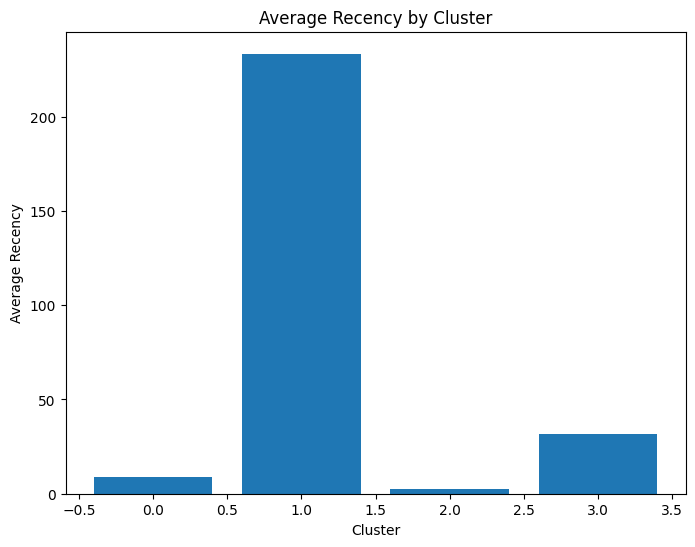

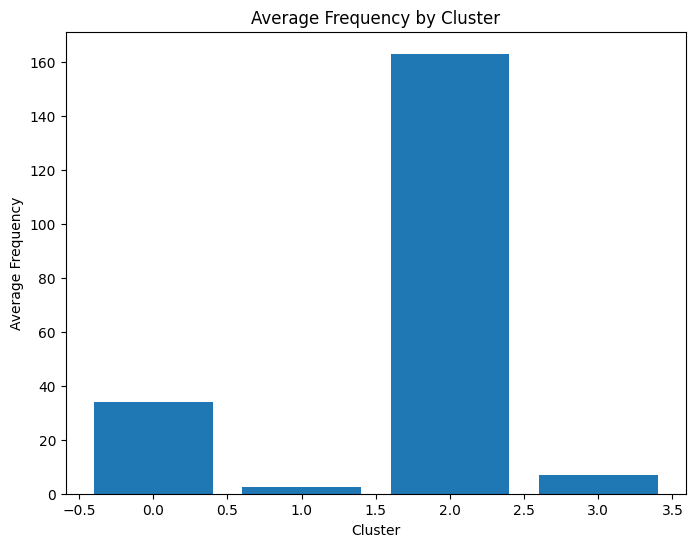

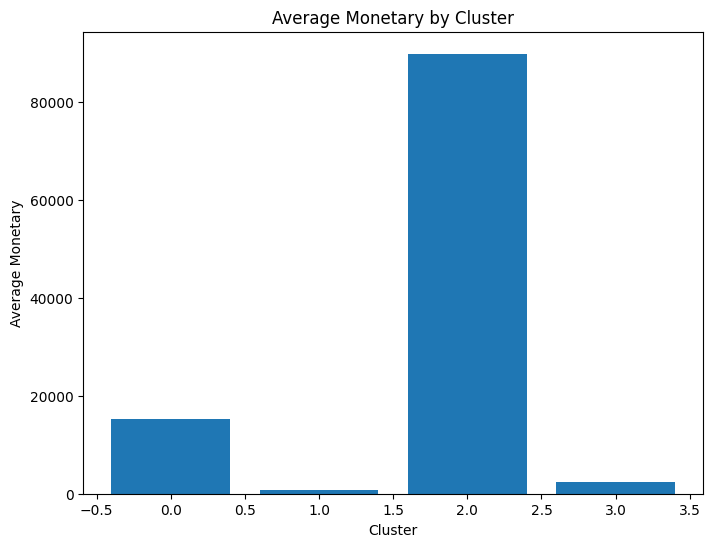

In [ ]:
# Ensure the dataset contains the necessary clustering output
# Assumption: 'Cluster' column exists with customer segmentation results

# Step 1: Prepare RFM metrics (if not already present)
if 'Recency' not in data.columns or 'Frequency' not in data.columns or 'Monetary' not in data.columns:
    print("Please calculate RFM metrics and cluster labels first.")

# Step 2: Analyze Each Cluster
# Group by 'Cluster' to analyze the average RFM metrics and customer distribution
cluster_profiles = data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'  # Count of customers in each cluster
}).rename(columns={'CustomerID': 'Customer_Count'}).reset_index()

# Add Cluster Descriptions (Example descriptions; customize as per your data)
cluster_profiles['Cluster_Description'] = [
    'High Recency, High Frequency, High Monetary' if x == 0 else
    'Low Recency, High Frequency, Moderate Monetary' if x == 1 else
    'High Recency, Low Frequency, Low Monetary'
    for x in cluster_profiles['Cluster']
]

# Display the Cluster Profiles
print("Cluster Profiles:")
print(cluster_profiles)

# Optional: Save the cluster profiles for reporting
cluster_profiles.to_csv('cluster_profiles.csv', index=False)

# Step 3: Visualize Cluster Profiles
import matplotlib.pyplot as plt

# Plot RFM metrics for each cluster
metrics = ['Recency', 'Frequency', 'Monetary']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.bar(cluster_profiles['Cluster'], cluster_profiles[metric])
    plt.title(f'Average {metric} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {metric}')
    plt.xticks(rotation=0)
    plt.show()


STEP 6 : Marketing Recommendations

**Define General Recommendations for Common RFM Segments**
Typical RFM segmentation divides customers into groups based on their purchasing behavior. The following are common segments and tailored strategies for them:

1. **Champions** (High Recency, High Frequency, High Monetary):
Characteristics: Loyal and high-spending customers.

Recommendations:
Offer exclusive loyalty programs or VIP memberships.
Provide early access to new products or premium services.
Send personalized thank-you notes or gifts.

2. **Loyal Customers** (Moderate Recency, High Frequency, Moderate Monetary):
Characteristics: Regular customers with consistent spending.

Recommendations:
Use targeted upselling or cross-selling strategies.
Introduce referral incentives to attract similar customers.
Offer discounts on bulk purchases or subscription plans.

3. **Potential Loyalists** (High Recency, Moderate Frequency, Moderate Monetary)
Characteristics: Recently acquired customers with promising behavior.

Recommendations:
Send welcome emails and introductory offers.
Provide onboarding materials or tutorials for product use.
Offer limited-time discounts to encourage repeat purchases.

4. **At-Risk Customers**(Low Recency, High Frequency, High Monetary):
Characteristics: Previously loyal customers showing signs of disengagement.

Recommendations:
Send re-engagement campaigns with exclusive offers.
Offer surveys to understand their concerns or challenges.
Highlight your brand’s unique value proposition through email or social media.

5. **Hibernating Customers**(Low Recency, Low Frequency, Low Monetary):
Characteristics: Infrequent and low-spending customers.

Recommendations:
Use retargeting ads or emails to bring them back.
Bundle products with discounts to increase their order size.
Highlight trending or new products to spark interest.

6.**Lost Customers** (Low Recency, Low Frequency, High Monetary):
Characteristics: Previously high-value customers who are now inactive.

Recommendations:
Send win-back campaigns with personalized messages.
Offer exclusive, high-value promotions.
Engage through surveys to understand their reasons for leaving.

In [ ]:
# Step 1: Review Cluster Profiles
print(cluster_profiles)

# Step 2: Define Recommendations for Each Cluster
cluster_recommendations = {
    0: "Champions: Offer loyalty programs, early access to products, and personalized thank-you notes.",
    1: "Loyal Customers: Promote bulk discounts, introduce referral incentives, and send targeted upselling offers.",
    2: "Potential Loyalists: Send welcome emails, onboarding materials, and limited-time discounts.",
    3: "At-Risk Customers: Run re-engagement campaigns, offer surveys to understand their concerns, and provide exclusive offers.",
    4: "Hibernating Customers: Use retargeting ads, promote product bundles, and highlight trending products."
}

# Print Recommendations for Each Cluster
for cluster, recommendation in cluster_recommendations.items():
    print(f"Cluster {cluster}: {recommendation}")


   Cluster     Recency   Frequency      Monetary  Customer_Count  \
0        0    8.931691   33.864297  15265.228834           81936   
1        1  233.447494    2.674316    839.410710           30244   
2        2    2.690789  163.206279  89796.821676           29019   
3        3   31.563476    6.990381   2336.111010          265630   

                              Cluster_Description  
0     High Recency, High Frequency, High Monetary  
1  Low Recency, High Frequency, Moderate Monetary  
2       High Recency, Low Frequency, Low Monetary  
3       High Recency, Low Frequency, Low Monetary  
Cluster 0: Champions: Offer loyalty programs, early access to products, and personalized thank-you notes.
Cluster 1: Loyal Customers: Promote bulk discounts, introduce referral incentives, and send targeted upselling offers.
Cluster 2: Potential Loyalists: Send welcome emails, onboarding materials, and limited-time discounts.
Cluster 3: At-Risk Customers: Run re-engagement campaigns, offer survey

STEP 8 : Visualization

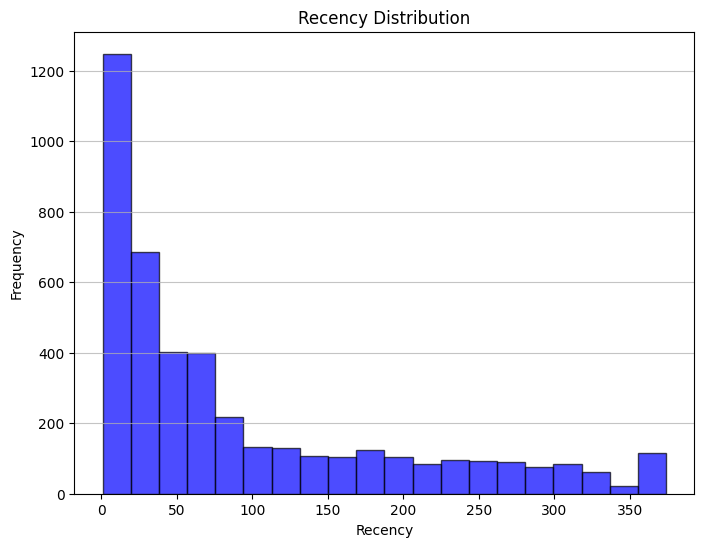

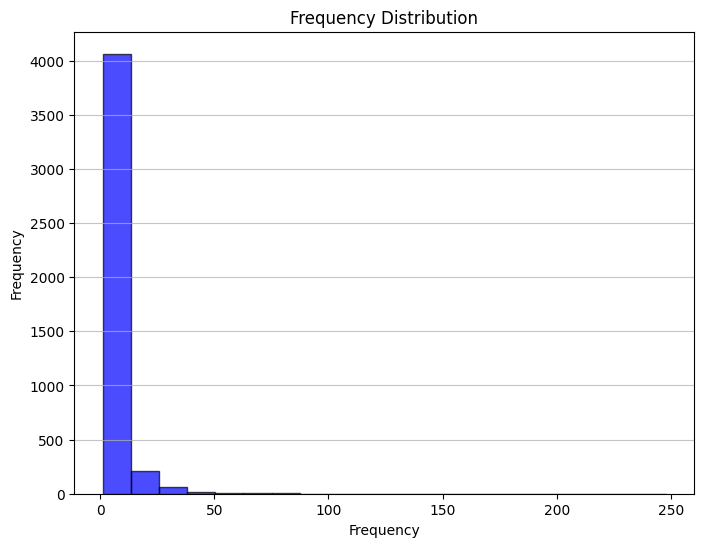

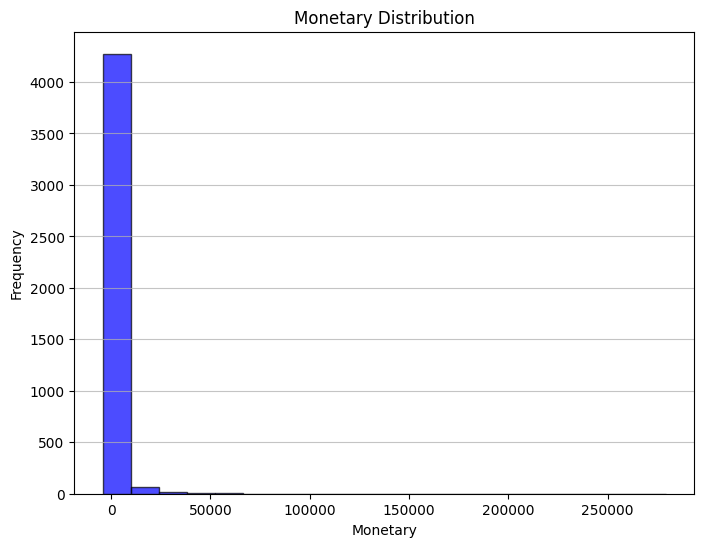

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the dataset has the required RFM and Cluster columns
if 'Cluster' not in rfm.columns:
    print("Please ensure the 'Cluster' column exists after performing clustering.")

# Bar Charts for RFM Distributions
metrics = ['Recency', 'Frequency', 'Monetary']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.hist(rfm[metric], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

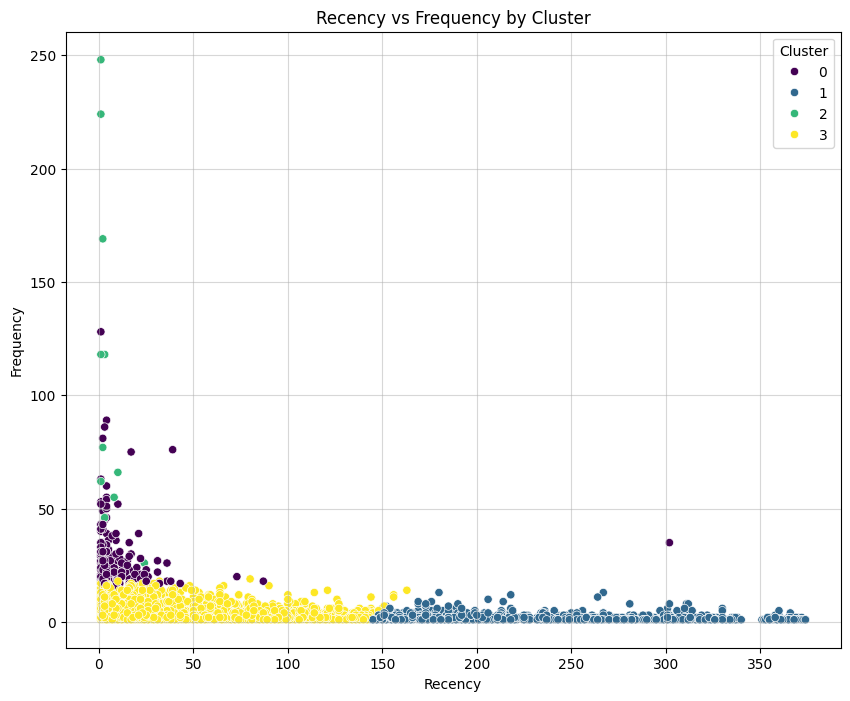

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the dataset has the required RFM and Cluster columns
if 'Cluster' not in rfm.columns:
    print("Please ensure the 'Cluster' column exists after performing clustering.")

    # Scatter Plots for Cluster Visualization
# Recency vs. Frequency colored by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Recency vs Frequency by Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid(alpha=0.5)
plt.show()


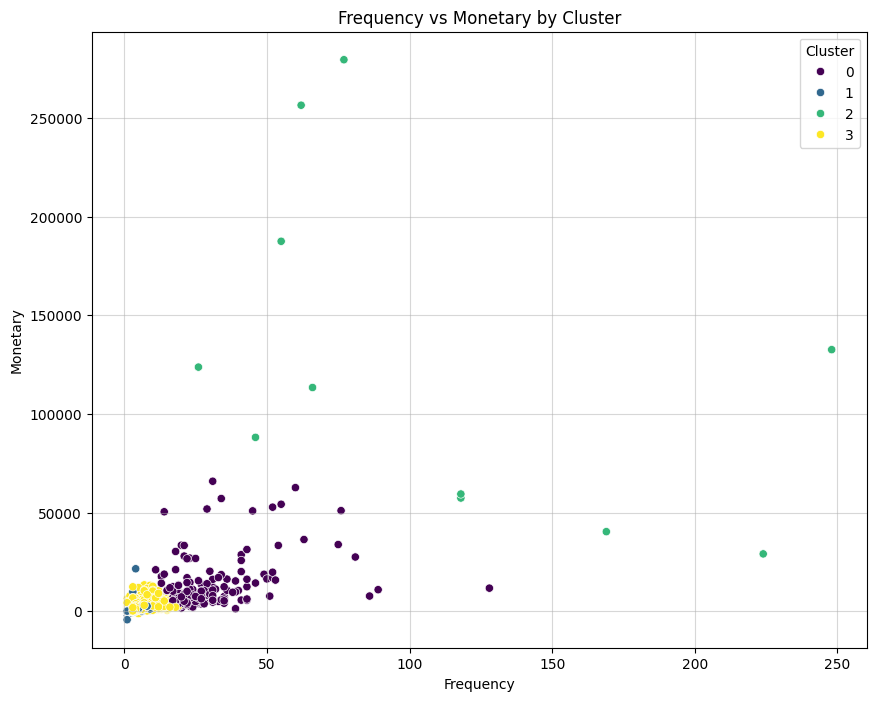

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the dataset has the required RFM and Cluster columns
if 'Cluster' not in rfm.columns:
    print("Please ensure the 'Cluster' column exists after performing clustering.")


# Frequency vs. Monetary colored by cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Frequency vs Monetary by Cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.grid(alpha=0.5)
plt.show()

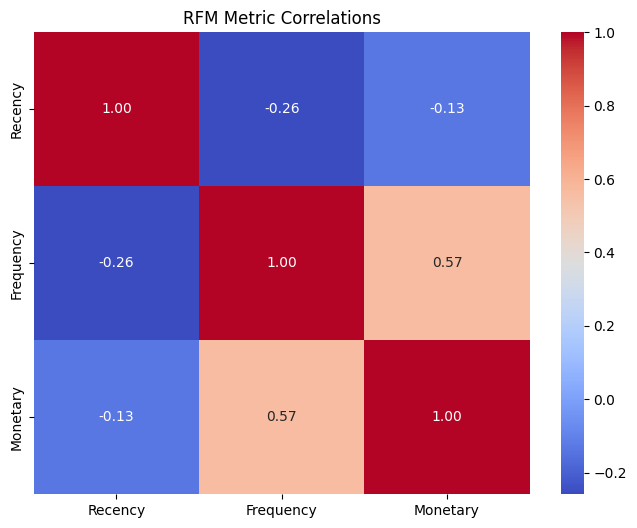

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the dataset has the required RFM and Cluster columns
if 'Cluster' not in rfm.columns:
    print("Please ensure the 'Cluster' column exists after performing clustering.")

# Heatmap for RFM Correlations
plt.figure(figsize=(8, 6))
correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('RFM Metric Correlations')
plt.show()

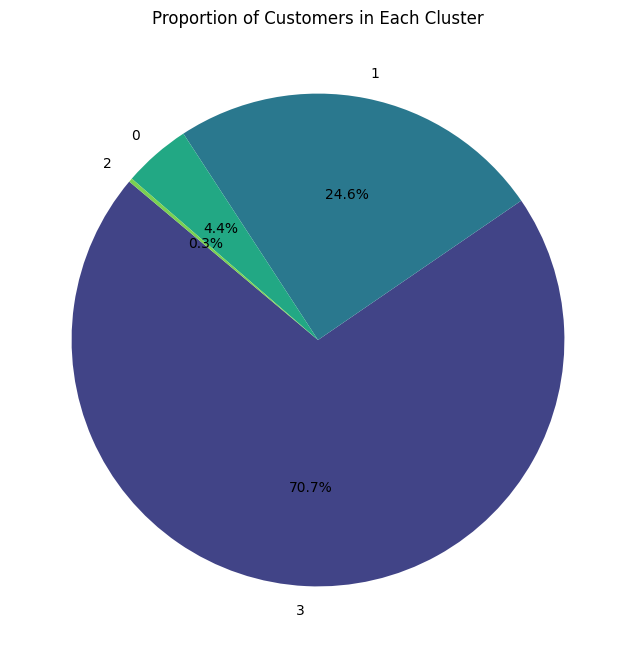

In [ ]:
# Pie Chart of Cluster Sizes
plt.figure(figsize=(8, 8))
cluster_sizes = rfm['Cluster'].value_counts()
plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(cluster_sizes)))
plt.title('Proportion of Customers in Each Cluster')
plt.show()


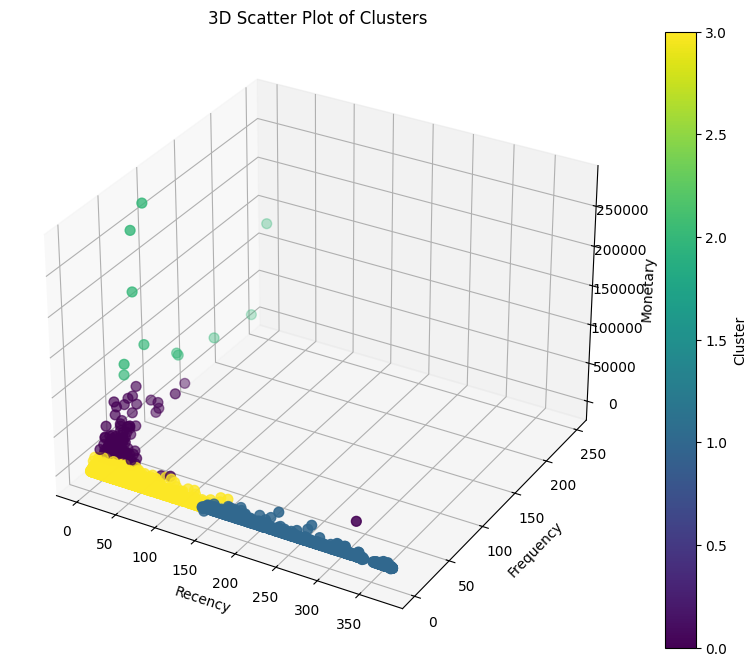

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter Plot of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Scatter Plot of Clusters')
plt.colorbar(sc, label='Cluster')
plt.show()


<ipython-input-30-f1a919e51787>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='Cluster', y='CLV', palette='viridis')


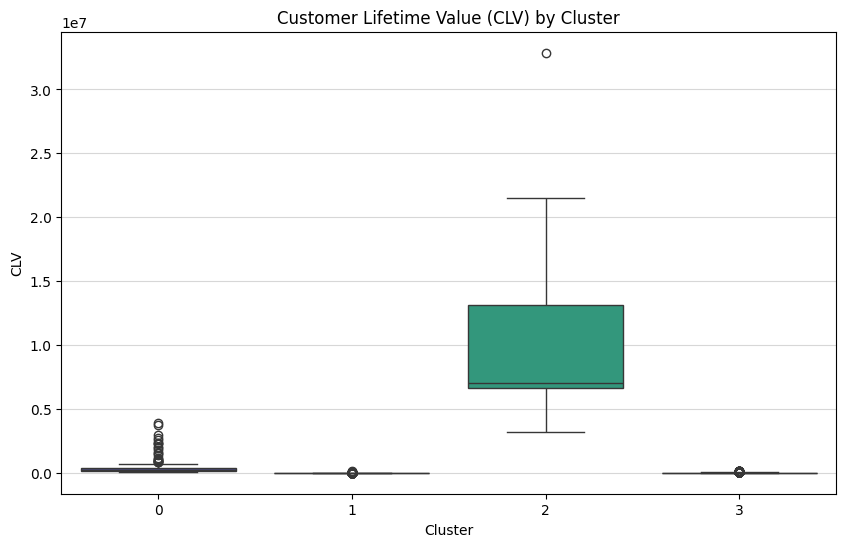

In [ ]:
# Calculate CLV (Monetary x Frequency as a proxy)
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency']

# Boxplot of CLV by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm, x='Cluster', y='CLV', palette='viridis')
plt.title('Customer Lifetime Value (CLV) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('CLV')
plt.grid(axis='y', alpha=0.5)
plt.show()
